# Using Self-supervised pretraining to complete an online data science challenge
### Part 1: Preparing the Encoder

*Brian Muhia, 2022*

I signed up to [this Zindi challenge on rice disease classification](https://zindi.africa/competitions/microsoft-rice-disease-classification-challenge/data). Rationale for doing this is that it seems, without exact calculation of cost-benefit, like a high impact problem to solve. 

In this dataset, each RGB image is paired with a corresponding RGNIR (RG-Near-Infra-Red) image of the same plant. Each image has a **single** label from the set 

`S = ['brown', 'blast', 'healthy']`. 

We want to make this, and other future challenges on this type of dataset simpler by utilising **weight sharing**: representing both images of the same object with the same weights, even if they're coming from two different cameras. After that, we can use those weights for the downstream task of classifying diseases. We can achieve this through self-supervised learning. For this task, we leave the labels alone and focus on training a model on data that looks like 
> **{Image , Image}** 

In the standard self-supervised learning setup for computer vision, we take a single image from the training set, make a copy, suitably augment that copy, then train a neural network to **minimize the distance between copies**. When such a model is well trained to convergence, we have a **task-agnostic encoder** whose representations can be used for further downstream tasks by transfer learning. Since we have two cameras pointing at rice, we get two images per sample in the training set. We can therefore construct any self-supervised learning task by assuming the image's copy is given, and that the difference in appearance coming from the NIR channel might as well be another augmentation of the RGB image. The other augmentations from the [SWAV paper/implementation](https://arxiv.org/abs/2006.09882) are kind of a bonus but it would better to ablate them. I'm releasing pretrained encoders from the best runs based on **XResnet-34 and Res2Net50**, which I'm calling **mwalimu-128 and mwalimu-224**, available [here on Google Drive](https://drive.google.com/drive/folders/1lV7Zl5XcI1dov6FkEgr6rmxES14Hc-xF).

> ![SwAV](images/swav.png)

For reference, I've added the image above, and here the abstract from the paper that introduced SWAV. For this challenge, our setup is on the right, and we already have *X1* and *X2*.
> ### Unsupervised Learning of Visual Features by Contrasting Cluster Assignments

https://arxiv.org/pdf/2006.09882.pdf

>**Absract**: Unsupervised image representations have significantly reduced the gap with supervised
>pretraining, notably with the recent achievements of contrastive learning
>methods. These contrastive methods typically work online and rely on a large number
>of explicit pairwise feature comparisons, which is computationally challenging.
>In this paper, we propose an online algorithm, SwAV, that takes advantage of contrastive
>methods without requiring to compute pairwise comparisons. Specifically,
>our method simultaneously clusters the data while enforcing consistency between
>cluster assignments produced for different augmentations (or “views”) of the same
>image, instead of comparing features directly as in contrastive learning. Simply put,
>we use a “swapped” prediction mechanism where we predict the code of a view
>from the representation of another view. Our method can be trained with large and
>small batches and can scale to unlimited amounts of data. Compared to previous
>contrastive methods, our method is more memory efficient since it does not require
>a large memory bank or a special momentum network. In addition, we also propose
>a new data augmentation strategy, multi-crop, that uses a mix of views with
>different resolutions in place of two full-resolution views, without increasing the
>memory or compute requirements. We validate our findings by achieving 75:3%
>top-1 accuracy on ImageNet with ResNet-50, as well as surpassing supervised
>pretraining on all the considered transfer tasks.

### Data setup and Visualisation

In [1]:
#export
from fastai.vision.all import *
from pytorch_block_sparse import BlockSparseLinear

In [2]:
#export
path = Path("/home/mu/.fastai/data/rice-disease-classification/")
files = get_image_files(path/"images")
files[0]

Path('/home/mu/.fastai/data/rice-disease-classification/images/id_dvirq2t8zp_rgn.jpg')

In [3]:
path.ls()

(#6) [Path('/home/mu/.fastai/data/rice-disease-classification/SampleSubmission.csv'),Path('/home/mu/.fastai/data/rice-disease-classification/images'),Path('/home/mu/.fastai/data/rice-disease-classification/Train.csv'),Path('/home/mu/.fastai/data/rice-disease-classification/Images.zip'),Path('/home/mu/.fastai/data/rice-disease-classification/events.out.tfevents.1657285352.exobrain.2031815.0'),Path('/home/mu/.fastai/data/rice-disease-classification/Test.csv')]

In [4]:
#export 
import PIL

In [5]:
img = PIL.Image.open(files[0])

In [6]:
# TODO: uncomment the next line to see the NIR image. 
# img

In [7]:
files[1]

Path('/home/mu/.fastai/data/rice-disease-classification/images/id_w4li9hey14.jpg')

In [8]:
files[1].name

'id_w4li9hey14.jpg'

In [9]:
type(files[1])

pathlib.PosixPath

In [10]:
img = PIL.Image.open(files[1])

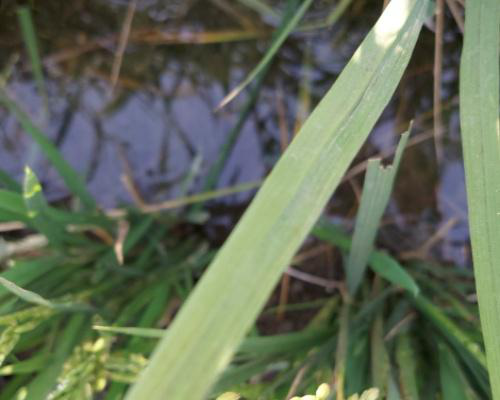

In [11]:
img

We need to write a function that finds the RGB picture matching a particular RGN image ID.  So we need to read the csv.

In [12]:
#export
train_df = pd.read_csv(path/"Train.csv")

In [13]:
train_df.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [14]:
#export
test_df = pd.read_csv(path/"Test.csv")

In [15]:
test_df.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_00vl5wvxq3_rgn.jpg
2,id_01hu05mtch.jpg
3,id_01hu05mtch_rgn.jpg
4,id_030ln10ewn.jpg


In [16]:
# export
def open_image(fname, size=224):
    "standard vision preprocessing: resize, convert image to tensor, normalize pixels, reorder channels"
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [17]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [18]:
# export
def find_matching_file(fname):
    """For strings matching the pattern: 'id_004wknd7qd_rgn.jpg', return them edited without the _rgn."""
    groups = re.match(r'^(.*)_(.*)_rgn.jpg$', fname.name).groups()
    return "_".join(groups)+".jpg"

In [19]:
# export
# group the files to make the process of matching RGB images with their RGN pairs a little easier
rgn = [f for f in files if "_rgn" in f.name]
train_fnames = [f for f in rgn if f.name in list(train_df.Image_id.values)]
valid_fnames = [f for f in rgn if f.name in list(test_df.Image_id.values)]

In [20]:
len(train_fnames), len(valid_fnames)

(2670, 1145)

In [21]:
train_fnames[0].name

'id_dvirq2t8zp_rgn.jpg'

In [22]:
find_matching_file(train_fnames[0])

'id_dvirq2t8zp.jpg'

In [23]:
train_df.iloc[1].Image_id

'id_004wknd7qd_rgn.jpg'

This list represents the training setup quite well as I work on loading & plotting infrastructure below

In [24]:
list(map(lambda x: (find_matching_file(x), x.name), train_fnames[:10]))

[('id_dvirq2t8zp.jpg', 'id_dvirq2t8zp_rgn.jpg'),
 ('id_fyx4sjjmqo.jpg', 'id_fyx4sjjmqo_rgn.jpg'),
 ('id_6brz9uie9y.jpg', 'id_6brz9uie9y_rgn.jpg'),
 ('id_1cq9rbrysn.jpg', 'id_1cq9rbrysn_rgn.jpg'),
 ('id_vbmasab4sj.jpg', 'id_vbmasab4sj_rgn.jpg'),
 ('id_wpj3o0ib5o.jpg', 'id_wpj3o0ib5o_rgn.jpg'),
 ('id_ab6vj4fvrn.jpg', 'id_ab6vj4fvrn_rgn.jpg'),
 ('id_7ulmi3qvmo.jpg', 'id_7ulmi3qvmo_rgn.jpg'),
 ('id_q0adhxcxud.jpg', 'id_q0adhxcxud_rgn.jpg'),
 ('id_6gfouzum5z.jpg', 'id_6gfouzum5z_rgn.jpg')]

In [25]:
# export
image_path = path/"images"

In [26]:
# export
# size=224
# size=64
size=128

In [27]:
# export
class SelfSupervisedTransform(Transform):
    def __init__(self, files):
        self.files = files
        
    def encodes(self, i):
        """Training setup: a RGB image next to a RGNIR image"""
        rgnir = self.files[i]
        rgb = self._draw(rgnir)
        img1,img2 = open_image(image_path/rgb, size=size),open_image(image_path/rgnir, size=size)
        return (TensorImage(img1), TensorImage(img2))
    
    def _draw(self, f):
        return find_matching_file(f)

In [28]:
# export
train_ds = SelfSupervisedTransform(train_fnames)
valid_ds = SelfSupervisedTransform(valid_fnames)

In [29]:
# export
train_tl= TfmdLists(range(len(train_fnames)), train_ds)
valid_tl= TfmdLists(range(len(valid_fnames)), valid_ds)

In [30]:
# export
# ImageNet weights can help in some problems
pretrained=imagenet=False

In [31]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [32]:
# export
if imagenet:
    stats = imagenet_stats
else:
    stats = ([-0.36366936564445496, 0.02002352848649025, -0.42636746168136597], # one-batch mean
             [0.8384413123130798, 0.9076182842254639, 0.8024894595146179]) # std

In [33]:
# export
from fastai.data.core import DataLoaders
bs=32
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=bs,
                             after_batch=[Normalize.from_stats(*stats), *aug_transforms()])

In [34]:
# export
dls.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


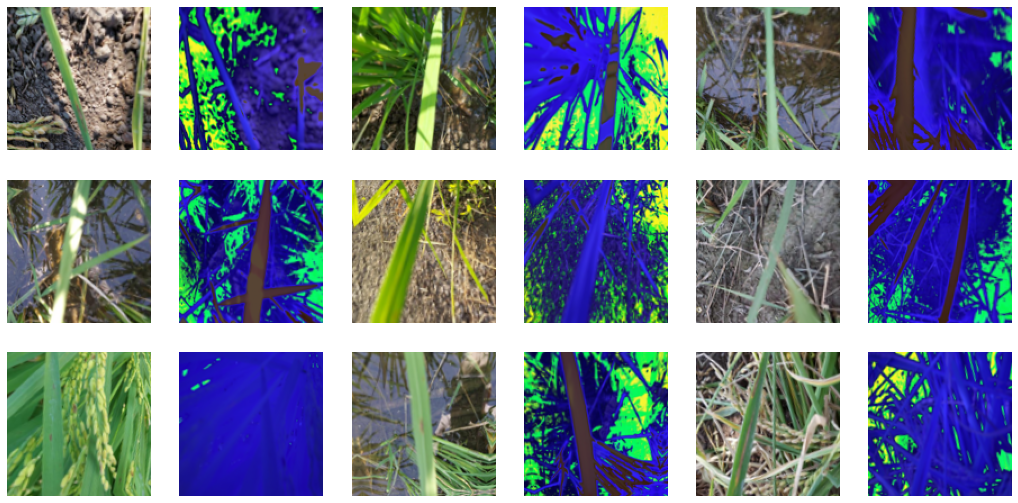

In [35]:
dls.show_batch()

In [36]:
class SelfSupervisedImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1, img2 = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title="RGB | RGNIR", ctx=ctx, **kwargs)

In [37]:
find_matching_file(files[0])

'id_dvirq2t8zp.jpg'

In [38]:
rgnir = PILImage.create(files[0])
rgb = PILImage.create(image_path/find_matching_file(files[0]))
ssi = SelfSupervisedImage(rgb, rgnir)

In [39]:
??explode_types

Signature: explode_types(o)
Source:   
def explode_types(o):
    "Return the type of `o`, potentially in nested dictionaries for thing that are listy"
    if not is_listy(o): return type(o)
    return {type(o): [explode_types(o_) for o_ in o]}
File:      ~/miniconda3/envs/rave/lib/python3.9/site-packages/fastcore/dispatch.py
Type:      function


In [40]:
# Showing how the training data is setup for this task, {Image, Image} like in the intro description
x, y = dls.one_batch()
explode_types((x, y))

{tuple: [fastai.torch_core.TensorImage, fastai.torch_core.TensorImage]}

In [41]:
# stats when not using a descendant of ImageNet
#mean, std =  x.mean(dim=[0,2,3]).tolist(),x.std(dim=[0,2,3]).tolist()

In [42]:
#mean,std

<AxesSubplot:title={'center':'RGB | RGNIR'}>

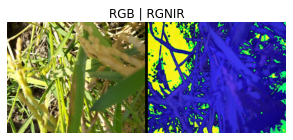

In [43]:
ssi.show()

### SWAV self-supervised learning

In [44]:
# export
from self_supervised.vision.swav import *
from self_supervised.layers import create_encoder

In [45]:
# export
torch.backends.cudnn.benchmark = True
WANDB = True
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

In [46]:
# export
arch = "xresnet34"#"res2net50" # "wide_resnet50_2"#
resize=size
epochs=600 #200

In [47]:
def create_mlp_module(dim,hidden_size,projection_size,bn=False,nlayers=2):
    "MLP module as described in papers, used as projection layer"
    l = []
    for i in range(nlayers-1):
        l += [BlockSparseLinear(dim, hidden_size) if i == 0 else BlockSparseLinear(hidden_size, hidden_size)]
        if bn: l += [nn.BatchNorm1d(hidden_size)]
        l += [nn.ReLU(inplace=True)]
    ls = l + [BlockSparseLinear(hidden_size, projection_size)]
    return nn.Sequential(*ls)

In [48]:
def init_default(m, func=nn.init.kaiming_normal_):
    "Initialize `m` weights with `func` and set `bias` to 0."
    if func:
        if hasattr(m, 'weight') and hasattr(m.weight, 'data'): func(m.weight.data)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)
    return m

def cond_init(m, func):
    "Apply `init_default` to `m` unless it's a batchnorm module"
    if (not isinstance(m, norm_types)) and requires_grad(m): init_default(m, func)

def apply_init(m, func=nn.init.kaiming_normal_):
    "Initialize all non-batchnorm layers of `m` with `func`."
    apply_leaf(m, partial(cond_init, func=func))

In [49]:
def create_swav_model(encoder, hidden_size=256, projection_size=128, n_protos=3008, bn=True, nlayers=2):
    "Create SwAV model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
    prototypes = BlockSparseLinear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.data.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

In [50]:
# export
encoder = create_encoder(arch, n_in=3, pretrained=pretrained)
model = create_swav_model(encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)],
                                       min_scales=[0.25,0.05],
                                       max_scales=[1.0,0.3],
                                       rotate=True, 
                                       rotate_deg=10)

In [51]:
# SaveModelCallback??

In [52]:
# export
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Algorithm":"BlockSparse SWAV", "Epochs": epochs, "Size": size, "ImageNet": imagenet, "Batch Size": bs}
    wandb.init(project="self-supervised-rice-disease-classification", config=xtra_config);

wandb: Currently logged in as: poppingtonic (nlug). Use `wandb login --relogin` to force relogin


In [53]:
# export
import timm

In [54]:
# export
sparsity= "block-sparse"
cbs = [SWAV(aug_pipelines=aug_pipelines,
            crop_assgn_ids=[0, 1],
            K=dls.bs*2**6, queue_start_pct=0.5),
       EarlyStoppingCallback(patience=100),
       SaveModelCallback(fname=f"swav-{sparsity}-best-{arch}-bs{bs}-size-{size}px"),
       WandbCallback(log_preds=False,log_model=True)]

Lamb has been shown to work well in various unsupervised learning benchmarks https://paperswithcode.com/method/lamb


In [55]:
Lamb??

Signature:
Lamb(
    params,
    lr,
    mom=0.9,
    sqr_mom=0.99,
    eps=1e-05,
    wd=0.0,
    decouple_wd=True,
)
Source:   
def Lamb(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-5, wd=0., decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, lamb_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)
File:      ~/miniconda3/envs/rave/lib/python3.9/site-packages/fastai/optimizer.py
Type:      function


In [56]:
SWAV.lf??

Signature: SWAV.lf(self, pred, *yb)
Docstring: <no docstring>
Source:   
    def lf(self, pred, *yb):
        log_ps, qs, loss = pred, yb[0], 0
        t = (qs.unsqueeze(1)*log_ps.unsqueeze(0)).sum(-1).mean(-1)
        for i, ti in enumerate(t): loss -= (ti.sum() - ti[i])/(len(ti)-1)/len(t)
        return loss
File:      ~/miniconda3/envs/rave/lib/python3.9/site-packages/self_supervised/vision/swav.py
Type:      function


In [57]:
# export
learn = Learner(dls, model, loss_func=SWAV.lf, cbs=cbs, opt_func=Lamb)

In [58]:
# b = dls.one_batch()
# learn._split(b)
# learn('before_batch')

In [59]:
# learn.swav.show(n=5);

In [60]:
# %pdb

In [61]:
# export
learn.to_fp16()

In [62]:
# move over swav-pretrain-rice-disease-epc37, we've got a new sherriff in town
# learn.load("run-bumbling-star-33-swav-xresnet34-pretrain-rice-disease-epc197-sz128px-bs32")
# learn.load("run-dandy-cosmos-12-swav-xresnet34-pretrain-rice-disease-epc19-sz224px-bs32")
# learn.load("swav-best-xresnet34-bs32-size-224px-divine-voice-3")
#learn.load("swav-best-xresnet34-bs32-size-128px-gallant-capybara")

In [63]:
# learn.unfreeze()

In [64]:
learn.lr_find()

RuntimeError: Exception occured in `SWAV` when calling event `after_pred`:
	CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Waiting for W&B process to finish... (success).


In [62]:
learn.unfreeze()

In [ ]:
# learn.fit_flat_cos(200, 1e-2, wd=1e-2)

In [ ]:
# export
learn.fit_one_cycle(800, 5e-2, wd=1e-2, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,time
0,6.163250,6.379409,00:59
1,6.182343,6.397837,00:58
2,6.204762,6.418967,00:59
3,6.177995,6.388650,00:59
4,6.180096,6.435221,00:59
5,6.155445,6.390632,00:59
6,6.167318,6.412711,00:59
7,6.155632,6.404360,00:59
8,6.153885,6.359773,00:59
9,6.159592,6.421362,00:59


Better model found at epoch 0 with valid_loss value: 6.379409313201904.
Better model found at epoch 8 with valid_loss value: 6.359772682189941.


In [ ]:
# export
run_name = wandb.run.name
if WANDB: wandb.finish()

In [67]:
# export
save_name = f'run-{run_name}-swav-{arch}-pretrain-rice-disease-sz{size}px-bs{bs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.plot_loss()